# Rakan's Playground




## Setup

### Package Installing

In [1]:
!pip install spotipy

### Google Drive & Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sys
PROJECT_ROOT = '/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

### Internal Imports

In [4]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, SpotifyTracksDataset, normalize_data_by_type, normalize_data, NormalizationType

In [5]:
sp = get_spotify_connection()

### PyTorch/Numpy/Pandas

In [6]:
import numpy as np
import pandas as pd
import random

pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

## Loading Data

### Load into DataFrame

Load the feature data from playlist into a dataframe

1.   Audio Features
2.   Track Info
3.   Artist Info
4.   Calculated Info
5.   Genres
6.   Target

In [87]:
playlist_name = "2sRZldX6n9oaII70OoO3zB"
playlist_name = "4wVOVUOLCGhkwcehwpju6V"

pl = PL.load_playlist(PROJECT_ROOT + "playlist_" + playlist_name)

Loaded playlist from file: /content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/playlist_4wVOVUOLCGhkwcehwpju6V


In [88]:
playlist_info_df = pd.DataFrame()

''' Audio Features '''
playlist_info_df['key'] = pd.Series([x['key'] for x in pl.playlist_information.track_features.values])
playlist_info_df['mode'] = pd.Series([x['mode'] for x in pl.playlist_information.track_features.values])
playlist_info_df['time_signature'] = pd.Series([x['time_signature'] for x in pl.playlist_information.track_features.values])
playlist_info_df['duration'] = pd.Series([x['duration_ms'] / 1000 for x in pl.playlist_information.track_features.values])
playlist_info_df['acousticness'] = pd.Series([x['acousticness'] for x in pl.playlist_information.track_features.values])
playlist_info_df['danceability'] = pd.Series([x['danceability'] for x in pl.playlist_information.track_features.values])
playlist_info_df['energy'] = pd.Series([x['energy'] for x in pl.playlist_information.track_features.values])
playlist_info_df['instrumentalness'] = pd.Series([x['instrumentalness'] for x in pl.playlist_information.track_features.values])
playlist_info_df['liveness'] = pd.Series([x['liveness'] for x in pl.playlist_information.track_features.values])
playlist_info_df['loudness'] = pd.Series([x['loudness'] for x in pl.playlist_information.track_features.values])
playlist_info_df['speechiness'] = pd.Series([x['speechiness'] for x in pl.playlist_information.track_features.values])
playlist_info_df['valence'] = pd.Series([x['valence'] for x in pl.playlist_information.track_features.values])
playlist_info_df['tempo'] = pd.Series([x['tempo'] for x in pl.playlist_information.track_features.values])

''' Track Info '''
playlist_info_df['explicit'] = pd.Series([x['explicit'] for x in pl.playlist_information.track_info.values])
playlist_info_df['release_date'] = pd.Series([x['album']['release_date'] for x in pl.playlist_information.track_info.values])

''' Artist Info '''
playlist_info_df['artist_followers'] = pd.Series([np.array([x['followers']['total'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
playlist_info_df['max_artist_popularity'] = pd.Series([np.array([x['popularity'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
playlist_info_df['avg_popularity_artist_top_tracks'] = pl.artist_top_track_information_df['avg_popularity_artist_top_tracks']
playlist_info_df['avg_duration_artist_top_tracks'] = pl.artist_top_track_information_df['avg_duration_artist_top_tracks']
playlist_info_df['avg_acousticness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks']
playlist_info_df['avg_danceability_artist_top_tracks'] = pl.artist_top_track_information_df['avg_danceability_artist_top_tracks']
playlist_info_df['avg_energy_artist_top_tracks'] = pl.artist_top_track_information_df['avg_energy_artist_top_tracks']
playlist_info_df['avg_instrumentalness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks']
playlist_info_df['avg_liveness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_liveness_artist_top_tracks']
playlist_info_df['avg_loudness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_loudness_artist_top_tracks']
playlist_info_df['avg_speechiness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks']
playlist_info_df['avg_valence_artist_top_tracks'] = pl.artist_top_track_information_df['avg_valence_artist_top_tracks']
playlist_info_df['avg_tempo_artist_top_tracks'] = pl.artist_top_track_information_df['avg_tempo_artist_top_tracks']

''' Calculated Info '''
playlist_info_df['change_from_avg_duration_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_duration_artist_top_tracks'] - playlist_info_df.duration).abs()
playlist_info_df['change_from_avg_acousticness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks'] - playlist_info_df.acousticness).abs()
playlist_info_df['change_from_avg_danceability_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_danceability_artist_top_tracks'] - playlist_info_df.danceability).abs()
playlist_info_df['change_from_avg_energy_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_energy_artist_top_tracks'] - playlist_info_df.energy).abs()
playlist_info_df['change_from_avg_instrumentalness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks'] - playlist_info_df.instrumentalness).abs()
playlist_info_df['change_from_avg_liveness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_liveness_artist_top_tracks'] - playlist_info_df.liveness).abs()
playlist_info_df['change_from_avg_loudness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_loudness_artist_top_tracks'] - playlist_info_df.loudness).abs()
playlist_info_df['change_from_avg_speechiness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks'] - playlist_info_df.speechiness).abs()
playlist_info_df['change_from_avg_valence_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_valence_artist_top_tracks'] - playlist_info_df.valence).abs()
playlist_info_df['change_from_avg_tempo_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_tempo_artist_top_tracks'] - playlist_info_df.tempo).abs()

''' Genres '''
genres_df = pl.genres_df

''' Target '''
playlist_info_df['popularity'] = pd.Series([x['popularity'] for x in pl.playlist_information.track_info.values])

### Information about data

In [89]:
print(f"Track Information Available:")
for col in list(playlist_info_df.columns):
  print(f"  - {col}")

Track Information Available:
  - key
  - mode
  - time_signature
  - duration
  - acousticness
  - danceability
  - energy
  - instrumentalness
  - liveness
  - loudness
  - speechiness
  - valence
  - tempo
  - explicit
  - release_date
  - artist_followers
  - max_artist_popularity
  - avg_popularity_artist_top_tracks
  - avg_duration_artist_top_tracks
  - avg_acousticness_artist_top_tracks
  - avg_danceability_artist_top_tracks
  - avg_energy_artist_top_tracks
  - avg_instrumentalness_artist_top_tracks
  - avg_liveness_artist_top_tracks
  - avg_loudness_artist_top_tracks
  - avg_speechiness_artist_top_tracks
  - avg_valence_artist_top_tracks
  - avg_tempo_artist_top_tracks
  - change_from_avg_duration_artist_top_tracks
  - change_from_avg_acousticness_artist_top_tracks
  - change_from_avg_danceability_artist_top_tracks
  - change_from_avg_energy_artist_top_tracks
  - change_from_avg_instrumentalness_artist_top_tracks
  - change_from_avg_liveness_artist_top_tracks
  - change_from_avg

In [90]:
for genre in list(genres_df.columns):
  print(f"  {genre[6:]}")

  atl hip hop
  deep talent show
  karaoke
  southern hip hop
  trap latino
  post-disco
  deep pop r&b
  pittsburgh rap
  ohio hip hop
  indie cafe pop
  country dawn
  psychedelic hip hop
  hollywood
  indietronica
  drill
  boy band
  smooth jazz
  uk alternative pop
  washington indie
  classic uk pop
  soul
  dark trap
  beatlesque
  oakland hip hop
  new jack swing
  big room
  conscious hip hop
  mexican pop
  scam rap
  art pop
  vapor pop
  alternative dance
  neo soul
  hard rock
  girl group
  contemporary vocal jazz
  indie soul
  indie rock
  puerto rican pop
  grunge
  boston hip hop
  rap dominicano
  dfw rap
  cincinnati rap
  modern folk rock
  reggaeton flow
  melodic rap
  zimdancehall
  worship
  europop
  folktronica
  canzone napoletana
  spiritual hip hop
  pop rock
  indie folk
  merseybeat
  classic rock
  shimmer pop
  west coast rap
  piano blues
  new rave
  art rock
  witch house
  a cappella
  alternative r&b
  wonky
  country
  new orleans rap
  crunk
  r

## Cleaning Data


In [91]:
cleaned_df = playlist_info_df.copy()

''' Discrete''' 
cleaned_df.time_signature = normalize_data_by_type(cleaned_df.time_signature, NormalizationType.DEFAULT)
cleaned_df.key = normalize_data_by_type(cleaned_df.key, NormalizationType.DEFAULT)
cleaned_df.explicit = cleaned_df.explicit *1
cleaned_df.release_date = 2020 - pd.to_datetime(cleaned_df.release_date).dt.year
cleaned_df.release_date = normalize_data_by_type(cleaned_df.release_date, NormalizationType.DEFAULT)

''' Continuous'''
cleaned_df.duration = normalize_data_by_type(cleaned_df.duration, NormalizationType.STD_CLAMP)
cleaned_df.avg_duration_artist_top_tracks = normalize_data_by_type(cleaned_df.avg_duration_artist_top_tracks, NormalizationType.STD_CLAMP)
cleaned_df.change_from_avg_duration_artist_top_tracks = normalize_data(cleaned_df.change_from_avg_duration_artist_top_tracks, data_min=0, data_max=playlist_info_df.duration.max()-playlist_info_df.duration.min())

cleaned_df.tempo = normalize_data_by_type(cleaned_df.tempo,NormalizationType.DEFAULT)
cleaned_df.avg_tempo_artist_top_tracks = normalize_data(cleaned_df.avg_tempo_artist_top_tracks, data_min=playlist_info_df.tempo.min(), data_max=playlist_info_df.tempo.max())
cleaned_df.change_from_avg_tempo_artist_top_tracks = normalize_data(cleaned_df.change_from_avg_tempo_artist_top_tracks, data_min=0, data_max=playlist_info_df.tempo.max()-playlist_info_df.tempo.min())

cleaned_df.loudness = normalize_data_by_type(cleaned_df.loudness, NormalizationType.DEFAULT)
cleaned_df.avg_loudness_artist_top_tracks = normalize_data(cleaned_df.avg_loudness_artist_top_tracks, data_min=playlist_info_df.loudness.min(), data_max=playlist_info_df.loudness.max())
cleaned_df.change_from_avg_loudness_artist_top_tracks = normalize_data(cleaned_df.change_from_avg_loudness_artist_top_tracks, data_min=0, data_max=playlist_info_df.loudness.max()-playlist_info_df.loudness.min())

cleaned_df.artist_followers = normalize_data_by_type(cleaned_df.artist_followers, NormalizationType.DEFAULT)

cleaned_df.max_artist_popularity = normalize_data(cleaned_df.max_artist_popularity, data_min=0, data_max=100)
cleaned_df.avg_popularity_artist_top_tracks = normalize_data(cleaned_df.avg_popularity_artist_top_tracks, data_min=0, data_max=100)


''' Add genre data '''
# cleaned_df = pd.concat([cleaned_df, genres_df], axis=1, sort=False)

''' Drop missing data '''
cleaned_df.dropna(inplace=True)

classification_df = cleaned_df.copy()
hit_cutoff = 70
classification_df['hit'] = (classification_df.popularity > hit_cutoff)*1
classification_df_with_popularity = classification_df.copy()
classification_df = classification_df.drop("popularity", axis=1)

In [92]:
num_hits = classification_df.hit.sum()
num_tracks = classification_df.shape[0]
print(f"Number of Hits: {num_hits}")
print(f"Total Number of Tracks: {num_tracks}")
print(f"Percent Hits: {round(num_hits/num_tracks * 100,2)} %")

Number of Hits: 498
Total Number of Tracks: 3261
Percent Hits: 15.27 %


## Balancing Data

In [18]:
def get_balanced_classification_df(df, hit_cutoff):

  main_df = df.copy()

  hit_df = main_df[main_df.hit == 1]
  non_hit_df = main_df[main_df.hit == 0]

  hit_count = hit_df.shape[0]
  non_hit_count = non_hit_df.shape[0]

  if hit_count > non_hit_count:
    diff = hit_count - non_hit_count
    for i in range(0, int(diff/non_hit_count)):
      extra_data = non_hit_df.iloc[0:diff]
      main_df = main_df.append(extra_data, ignore_index=True)

    extra_data = non_hit_df.iloc[0:int(diff%non_hit_count)]
    main_df = main_df.append(extra_data, ignore_index=True)

  else:
    diff = non_hit_count - hit_count
    for i in range(0,int(diff/hit_count)):
      extra_data = hit_df.iloc[0:diff]
      main_df = main_df.append(extra_data, ignore_index=True)
    extra_data = hit_df.iloc[0:int(diff%hit_count)]
    main_df = main_df.append(extra_data, ignore_index=True)

  return main_df

## Exploring Data

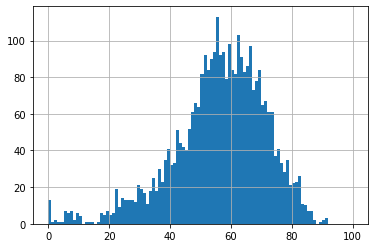

In [94]:
classification_df_with_popularity[classification_df_with_popularity.popularity > -1].popularity.hist(bins=range(0,101))


In [19]:
classification_df_with_popularity.corr()['popularity']


key                                                   0.005107
mode                                                 -0.052734
time_signature                                        0.097475
duration                                              0.014949
acousticness                                         -0.024420
danceability                                          0.173783
energy                                                0.020115
instrumentalness                                     -0.175949
liveness                                             -0.081200
loudness                                              0.209961
speechiness                                           0.043007
valence                                              -0.040682
tempo                                                 0.016019
explicit                                              0.220323
release_date                                         -0.261857
artist_followers                                      0

In [20]:
def plot_feature_and_target(dataframe_to_plot, feature, target):
  cols = [feature, target]
  dataframe_to_plot = dataframe_to_plot[cols]
  dataframe_to_plot.plot.scatter(x=feature, y=target)
  return

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


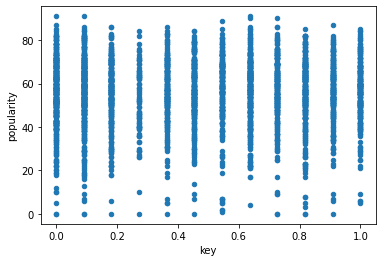

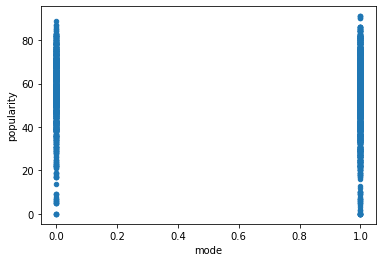

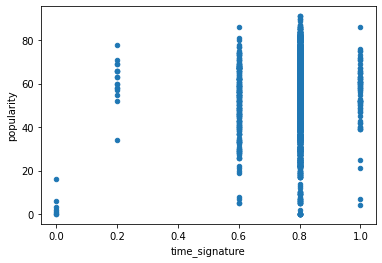

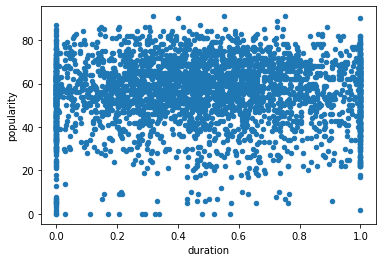

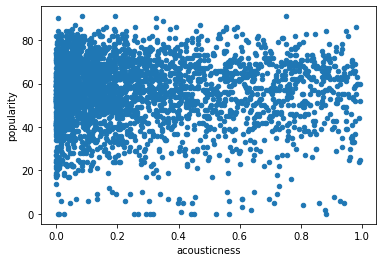

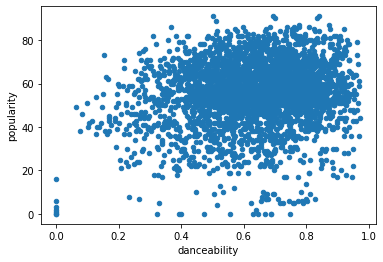

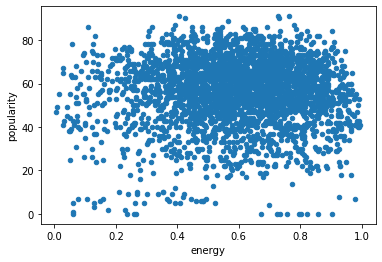

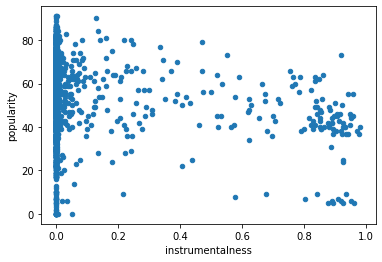

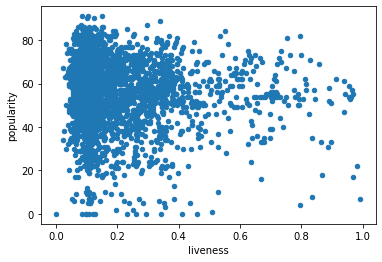

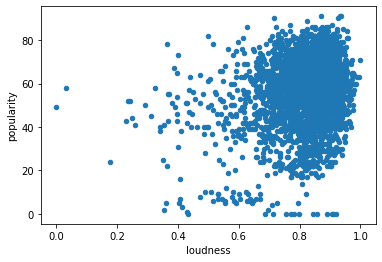

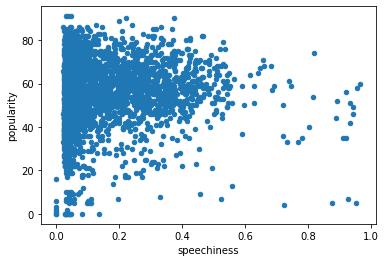

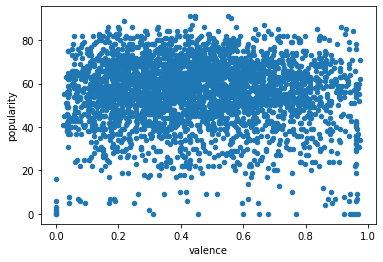

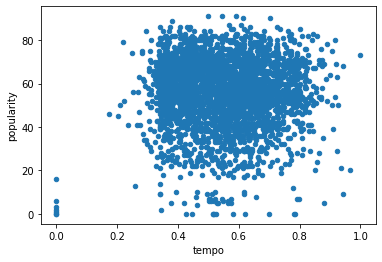

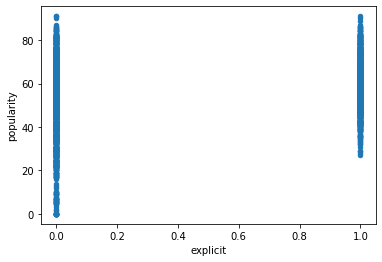

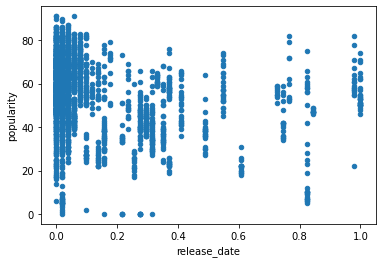

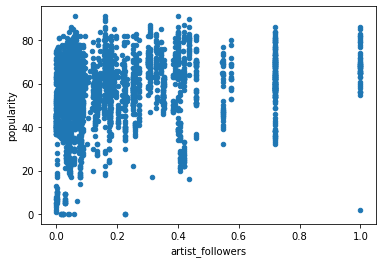

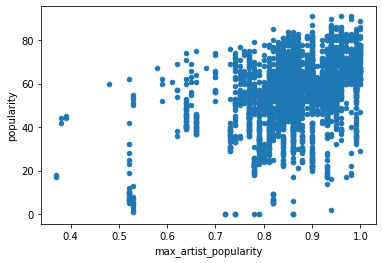

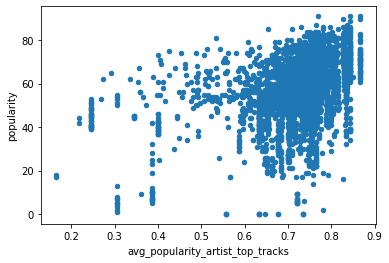

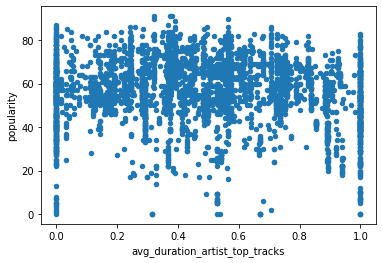

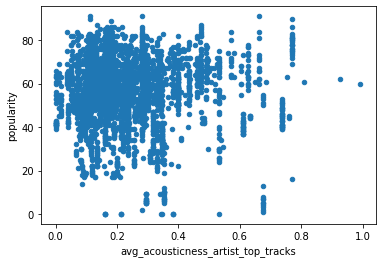

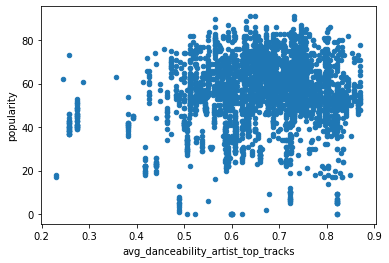

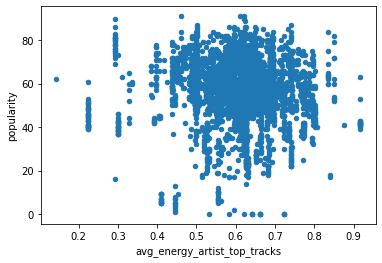

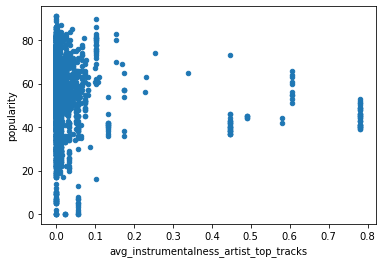

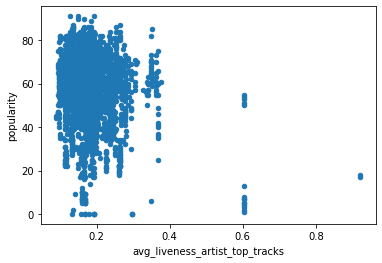

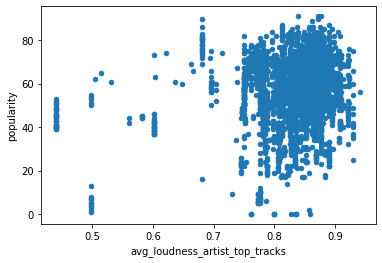

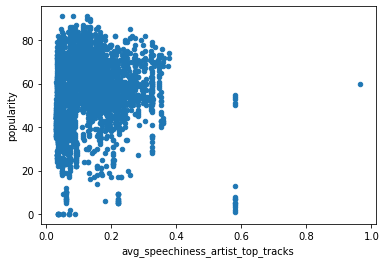

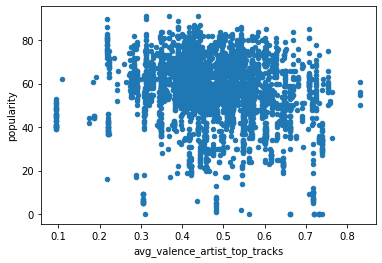

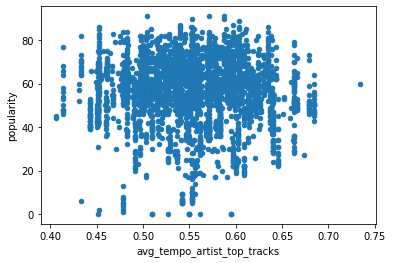

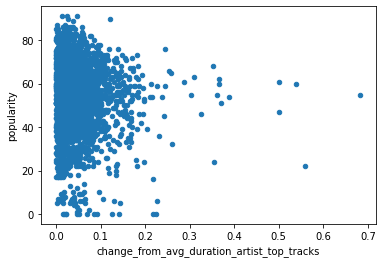

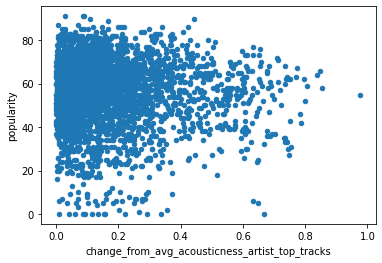

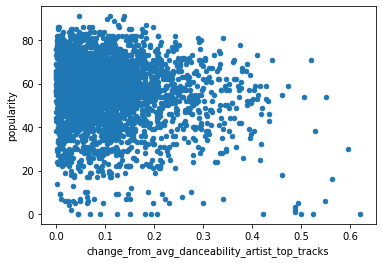

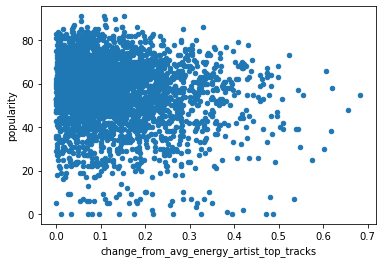

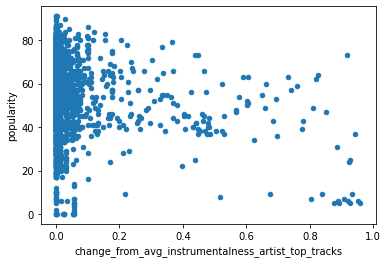

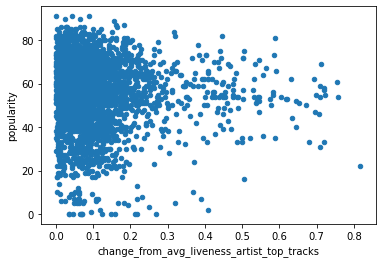

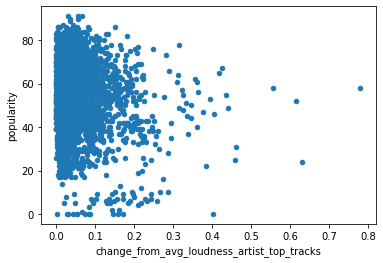

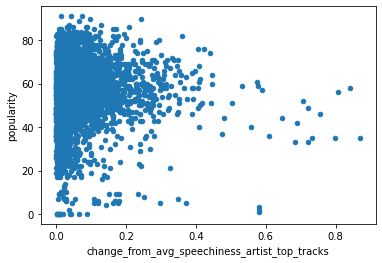

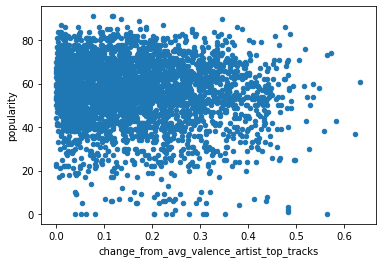

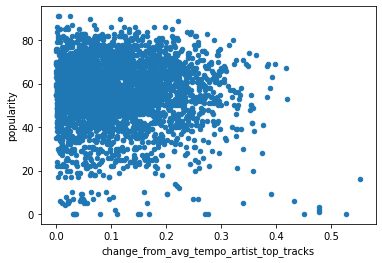

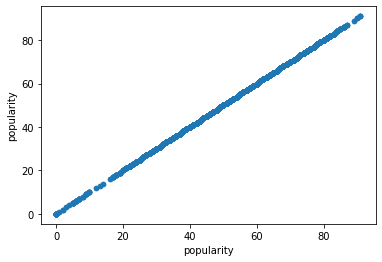

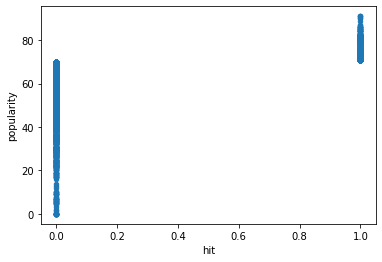

In [21]:
dataframe_to_plot = classification_df_with_popularity
target = 'popularity'

for col in dataframe_to_plot.columns:
  plot_feature_and_target(dataframe_to_plot, col, target)

## Creating Dataset

In [24]:
TRAIN_PCT = 0.7
VALID_PCT = 0.15

dataframe_to_use = classification_df
dataset_target = 'hit'
features = list(dataframe_to_use.columns.copy())
features.remove(dataset_target)

''' Scramble DataFrame '''
seed_torch(0)
dataframe_to_use = dataframe_to_use.sample(frac=1).reset_index(drop=True)

''' Split Data '''
num_data = dataframe_to_use.shape[0]

num_train = int(num_data * TRAIN_PCT)
num_val = int(num_data * VALID_PCT)
num_test = num_data - num_train - num_val

train_df = dataframe_to_use.iloc[0:num_train]
balanced_train_df = get_balanced_classification_df(train_df, hit_cutoff)
val_df = dataframe_to_use.iloc[num_train:num_train+num_val]
test_df = dataframe_to_use.iloc[num_train+num_val:num_data]

''' Create Datasets '''
train = SpotifyTracksDataset(train_df, features, dataset_target)
balanced_train = SpotifyTracksDataset(balanced_train_df, features, dataset_target)
val = SpotifyTracksDataset(val_df, features, dataset_target)
test = SpotifyTracksDataset(test_df, features, dataset_target)
full_dataset = SpotifyTracksDataset(dataframe_to_use, features, dataset_target)

## Model

In [25]:
class ClassificationNet(nn.Module):
  def __init__(self):
    super(ClassificationNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.Tanh(),
        nn.Linear(100, 50),
        nn.Tanh(),
        nn.Linear(50, 20),
        nn.Tanh(),
        nn.Linear(20, 2)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

## Training

### Helper Functions

In [26]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    k = random.randint(0, len(data)-1)
    features, target = data[k]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

In [27]:
import matplotlib.pyplot as plt

def subsample_series(series, subsampling=1):
  '''
  Subsamples data series
  '''
  indices = np.arange(0,len(series),subsampling)
  subsampled_series = series[indices]
  return indices + 1, subsampled_series

def plot_data(data, multiple_series=False, subsampling=1, labels=None, title="", xlabel="", ylabel=""):
    plt.title(title)
    
    n = len(data)

    if multiple_series:
      for i, series in enumerate(data, 0):
        indices, subsampled_series = subsample_series(np.array(series), subsampling=subsampling)
        if labels:
          plt.plot(indices, subsampled_series, label=labels[i])
        else:
          plt.plot(indices, subsampled_series,)
    else:
      indices, subsampled_series = subsample_series(np.array(data), subsampling=subsampling)
      if labels:
          plt.plot( indices, subsampled_series, label=labels)
      else:
        plt.plot( indices, subsampled_series)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if labels:
      plt.legend(loc='best')

    plt.show()

In [28]:
def get_error_classification(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()
  
  error_rate = 1 - (total_error/len(data))
  return error_rate

def get_stats_classification(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0
  total_loss = 0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error_rate = 1 - (total_error/len(data))
  return error_rate, avg_loss

### Train Function

In [29]:
def train_net_classification(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)

      targets = targets.squeeze(1).long()
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      out = torch.softmax(out, dim=1)

      epoch_loss += loss.item()
      epoch_error += out.argmax(dim=1).eq(targets).sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = 1 - (epoch_error / len(train_data))
    val_error_rate, val_loss = get_stats_classification(model, valid_data, criterion, bs=bs)
    model.train()
    
    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Accuracy by Epoch", xlabel='Epoch', ylabel='Error Rate')

### Training Model

#### Successful Model

Streaming output truncated to the last 5000 lines.

Epoch 4287
  Train Error: 0.006735751295336767
  Valid Error: 0.21676891615541927
  Train Loss: 0.04024157673120499
  Valid Loss: 0.5191648006439209


Epoch 4288
  Train Error: 0.007253886010362698
  Valid Error: 0.21676891615541927
  Train Loss: 0.04208028642460704
  Valid Loss: 0.5198953151702881


Epoch 4289
  Train Error: 0.00829015544041456
  Valid Error: 0.22085889570552142
  Train Loss: 0.04183532320894301
  Valid Loss: 0.5203860402107239


Epoch 4290
  Train Error: 0.005958549222797926
  Valid Error: 0.21676891615541927
  Train Loss: 0.0408378429710865
  Valid Loss: 0.5184579491615295


Epoch 4291
  Train Error: 0.006476683937823857
  Valid Error: 0.21676891615541927
  Train Loss: 0.04056535451672971
  Valid Loss: 0.5241028666496277


Epoch 4292
  Train Error: 0.006735751295336767
  Valid Error: 0.21881390593047034
  Train Loss: 0.04038189724087715
  Valid Loss: 0.5240948796272278


Epoch 4293
  Train Error: 0.0067357512953367

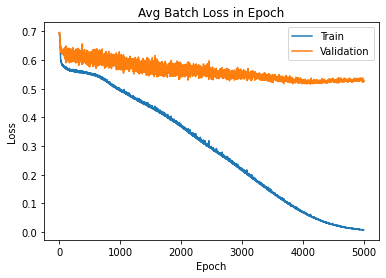

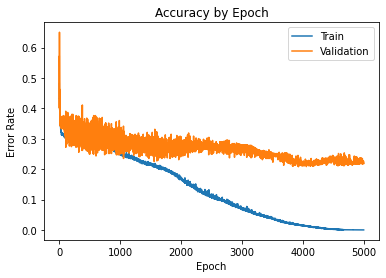

In [30]:
model = ClassificationNet()
model.to(device)

train_net_classification(model, balanced_train, val, bs=512, lr=0.0002, wd=0, epochs=5000)

#### Playground

Streaming output truncated to the last 5000 lines.

Epoch 287
  Train Error: 0.2919689119170984
  Valid Error: 0.36809815950920244
  Train Loss: 0.5344865960030516
  Valid Loss: 0.6242707818746567


Epoch 288
  Train Error: 0.2904145077720207
  Valid Error: 0.30470347648261764
  Train Loss: 0.5341471741514757
  Valid Loss: 0.5972310863435268


Epoch 289
  Train Error: 0.2937823834196891
  Valid Error: 0.3312883435582822
  Train Loss: 0.5348912093264997
  Valid Loss: 0.6161784827709198


Epoch 290
  Train Error: 0.2867875647668394
  Valid Error: 0.3006134969325154
  Train Loss: 0.5322320192805992
  Valid Loss: 0.5976039804518223


Epoch 291
  Train Error: 0.2896373056994819
  Valid Error: 0.278118609406953
  Train Loss: 0.533726501809664
  Valid Loss: 0.5861263200640678


Epoch 292
  Train Error: 0.28575129533678756
  Valid Error: 0.28016359918200406
  Train Loss: 0.53230725930742
  Valid Loss: 0.591321550309658


Epoch 293
  Train Error: 0.28523316062176163
  Valid Error: 0.31697341513

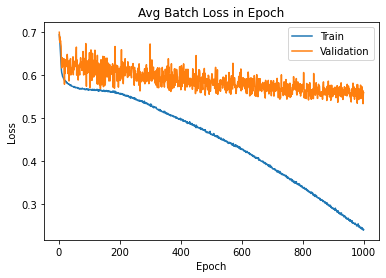

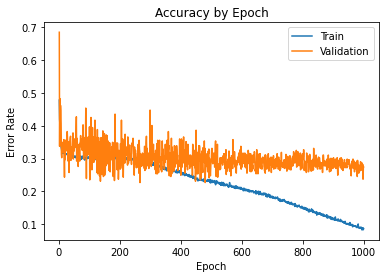

In [31]:
model = ClassificationNet()
model.to(device)

train_net_classification(model, balanced_train, val, bs=32, lr=0.0001, wd=0, epochs=1000)

## Evaluation

### Helper Functions

In [32]:
def get_baseline_classification_error(df):
  total_error = 0
  correct = (df.hit == (df.avg_popularity_artist_top_tracks*100 > hit_cutoff)).sum()
  # correct = (df.hit == (df.max_artist_popularity*100 > hit_cutoff)).sum()
  error_rate = 1 - (correct/df.shape[0])
  return error_rate

In [55]:
def get_confusion_matrix(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  matrix = np.zeros(shape=(2,2))

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)

    # Non-hit Correct
    matrix[0,0] += ((out.argmax(dim=1) == 0) * (targets == 0)).sum().item()
    # Hit Correct
    matrix[1,1] += ((out.argmax(dim=1) == 1) * (targets == 1)).sum().item()
    # Hit Incorrect (False Negative)
    matrix[0,1] += ((out.argmax(dim=1) == 0) * (targets == 1)).sum().item()
    # Non-Hit Incorrect (False Positive)
    matrix[1,0] += ((out.argmax(dim=1) == 1) * (targets == 0)).sum().item()
  
  return matrix

def get_baseline_confusion(df):
  total_error = 0
  matrix = np.zeros(shape=(2,2))

  # Non-hit Correct
  matrix[0,0] += ((df.avg_popularity_artist_top_tracks*100 <= 70) & (df.hit == 0)).sum().item()
  # Hit Correct
  matrix[1,1] += ((df.avg_popularity_artist_top_tracks*100 > 70) & (df.hit == 1)).sum().item()
  # Hit Incorrect (False Negative)
  matrix[0,1] += ((df.avg_popularity_artist_top_tracks*100 <= 70) & (df.hit == 1)).sum().item()
  # Non-Hit Incorrect (False Positive)
  matrix[1,0] += ((df.avg_popularity_artist_top_tracks*100 > 70) & (df.hit == 0)).sum().item()

  return matrix

def print_confusion_matrix(matrix):
  print(f"--------------------------------------")
  print(f"                   Actual")
  print(f"                  0      1")
  print(f"Predicted  0    {round(matrix[0,0]*100,2)}   {round(matrix[0,1]*100,2)}")
  print(f"           1    {round(matrix[1,0]*100,2)}   {round(matrix[1,1]*100,2)}")
  print(f"--------------------------------------")

### Model Accuracy

In [56]:
error = get_error_classification(model, balanced_train)
print(f"Balanced Training Error: {round(error*100,2)}%")

error = get_error_classification(model, train)
print(f"Training Error: {round(error*100,2)}%")

error = get_error_classification(model, val)
print(f"Validation Error: {round(error*100,2)}%")

error = get_error_classification(model, test)
print(f"Testing Error: {round(error*100,2)}%")

error = get_error_classification(model, full_dataset)
print(f"Full Dataset Error: {round(error*100,2)}%")

Balanced Training Error: 8.24%
Training Error: 10.78%
Validation Error: 27.4%
Testing Error: 30.0%
Full Dataset Error: 16.16%


In [62]:
print(f"\nBalanced Training Matrix:")
matrix = get_confusion_matrix(model, balanced_train) / len(balanced_train)
print_confusion_matrix(matrix)


print(f"\nTraining Matrix:")
matrix = get_confusion_matrix(model, train) / len(train)
print_confusion_matrix(matrix)


print(f"\nValidation Matrix:")
matrix = get_confusion_matrix(model, val) / len(val)
print_confusion_matrix(matrix)


print(f"\nTesting Matrix:")
matrix = get_confusion_matrix(model, test) / len(test)
print_confusion_matrix(matrix)


print(f"\nFull Dataset Matrix:")
matrix = get_confusion_matrix(model, full_dataset) / len(full_dataset)
print_confusion_matrix(matrix)


Balanced Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    44.07   2.31
           1    5.93   47.69
--------------------------------------

Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    74.54   0.74
           1    10.04   14.68
--------------------------------------

Validation Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    66.87   8.59
           1    18.81   5.73
--------------------------------------

Testing Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    62.04   7.55
           1    22.45   7.96
--------------------------------------

Full Dataset Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    71.51   2.94
           1    13

### Baseline Model Accuracy

In [60]:
baseline_error = get_baseline_classification_error(balanced_train_df)
print(f"Balanced Training Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(train_df)
print(f"Training Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(val_df)
print(f"Validation Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(test_df)
print(f"Testing Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(pd.concat([train_df, val_df, test_df], axis=0))
print(f"Full Dataset Baseline Error: {round(baseline_error*100,2)}%")


Balanced Training Baseline Error: 38.6%
Training Baseline Error: 57.67%
Validation Baseline Error: 58.28%
Testing Baseline Error: 58.57%
Full Dataset Baseline Error: 57.9%


In [59]:
print(f"\nBalanced Training Matrix:")
matrix = get_baseline_confusion(balanced_train_df) / balanced_train_df.shape[0]
print_confusion_matrix(matrix)


print(f"\nTraining Matrix:")
matrix = get_baseline_confusion(train_df) / train_df.shape[0]
print_confusion_matrix(matrix)


print(f"\nValidation Matrix:")
matrix = get_baseline_confusion(val_df) / val_df.shape[0]
print_confusion_matrix(matrix)


Balanced Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    16.92   5.52
           1    33.08   44.48
--------------------------------------

Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    28.62   1.71
           1    55.96   13.72
--------------------------------------

Validation Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    29.24   1.84
           1    56.44   12.47
--------------------------------------


# Regression Stuff

### Model

In [ ]:
class RegressionNet(nn.Module):
  def __init__(self):
    super(RegressionNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,1)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

### Training

In [ ]:
def get_error_regression(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)
  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  error_rate = total_error/len(data)
  return error_rate

def get_stats_regression(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0.0
  total_loss = 0.0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error = total_error/len(data)
  return error, avg_loss

In [ ]:
def train_net_regression(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0.0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = epoch_error / len(train_data)
    val_error_rate, val_loss = get_stats_regression(model, valid_data, criterion, bs=bs)
    model.train()

    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print()
    predict_some(model, train_data, 2)
    print()
    predict_some(model, valid_data, 2)
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Avg Error by Epoch", xlabel='Epoch', ylabel='Avg Error')

In [ ]:
model = RegressionNet()
model.to(device)

train_net_regression(model, train, val, bs=512, lr=0.0001, wd=0, epochs=1000)

NameError: ignored

### Evaluation


In [ ]:
def get_baseline_regression_error(df):
  total_error = 0
  errors = (df.max_artist_popularity*100 - df.popularity).abs()
  errors = (df.avg_popularity_artist_top_tracks*100 - df.popularity).abs()
  total_error = errors.sum()
  error_rate = total_error/df.shape[0]
  return error_rate

In [ ]:
error = get_error_regression(model, test)
print(error)
error = get_error_regression(model, full_dataset)
print(error)

1.3287614371559837
1.3246404070379347


In [ ]:
baseline_error = get_baseline_regression_error(train_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(val_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(test_df)
print(baseline_error)

baseline_error = get_baseline_regression_error(regression_df)
print(baseline_error)

19.919915253461415
20.68003212275486
20.30826438249911
20.092127926842924
